# About Dataset
The dataset used in this notebook consist of 1.6M tweets from various users.
Dataset has various columns such as "target", "ids", "date", "flag", "user", "text".
Dataset has been used for sentiment Analysis.
IN this Dataset 
0 - Negative
4 - Neutral
8 - Positive

Although, It is mentioned that the dataset contains tweets of neutral emotions but while analysing the
dataset i found that there were no neutral tweets.

# Notebook Overview

Step - 1: We first import all necessary libraries which would be used in the notebook.
Step - 2: Here we remove the unecessary columns and limit our dataset to 30,000 tweets and then  visualize the data.
Step - 3: Now, We clean our dataset and prepare it for NLP.
Step - 4: We try common machine learning classifiers to classify tweets into positive and negative tweets
Step - 5: Here, we a try a simple 3-layer LSTM model to classify tweets.

# Accuracy

1. Gaussian Naive Bayes Classifer - 54.85 %
2. Logistic Regression - 73.63 %
3. LSTM - 78 %

In [1]:
#Importing libraries

#NUMPY, PANDAS AND MATPLOTLIB
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

#Importing nltk libraries for data preprocessing and cleaning texts

#re - for regular expressions
#nltk - natural language processing library
#stopwords contains all word that do not provide any specific meaning for nlp. i.e., words like "a","an","this",etc
#porterStemmer for stemming purpose
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

#Importing sklearn count vectorizer for vectorization
from sklearn.feature_extraction.text import CountVectorizer

#Importing train test split for splitting dataset into train ans test dataset
from sklearn.model_selection import train_test_split

#Importing Naive bayes (Gaussian) and logistic regression classifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

#Importing keras 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM

[nltk_data] Downloading package stopwords to /home/sumit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


In [2]:
#Column Names
Dataset_columns = ["target", "ids", "date", "flag", "user", "text"]

#Importing dataset
dataset = pd.read_csv('dataset.csv', encoding='ISO-8859-1', names=Dataset_columns)
dataset.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
# Here the size of dataset is 1.6M but we are only going to deal with 30,000 tweets due to unavailabiltiy 
# of computing power
print("Dataset size:", len(dataset))

Dataset size: 1600000


In [4]:
#Dropping unimportant columns such as tweet id, user name, date
dataset.drop(["ids", "date", "flag", "user"], axis = 1, inplace = True)
dataset.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [5]:
#In the dataset for negative tweet have target value of 0 and positive tweets have
# a target value of 8.
# Changing them from 0 to -1 and from 8 to 1
def positive_negative(label):
    if(label == 0):
        return -1
    else:
        return 1

In [6]:
#Changing dataset.target value of 0 to -1 and 8 to +1
dataset.target = dataset.target.apply(lambda x: positive_negative(x))
dataset.head()

,target,text
0,-1,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,-1,is upset that he can't update his Facebook by ...
2,-1,@Kenichan I dived many times for the ball. Man...
3,-1,my whole body feels itchy and like its on fire
4,-1,"@nationwideclass no, it's not behaving at all...."


In [7]:
#Shuffling dataset.
# so that negative and positive tweets are shuffled
dataset = dataset.sample(frac = 1).reset_index(drop=True)
dataset.head()

,target,text
0,-1,@kristimcarlson i'd luv to but i got no inet a...
1,1,NBA Finals. Banners are for the LAKERS!!
2,-1,"In the garden, learning lines... Scorching day..."
3,-1,svn-bisect ....
4,-1,"says i know its wrong to like you,, but i real..."


Text(0.5,1,'Dataset labels distribuition')

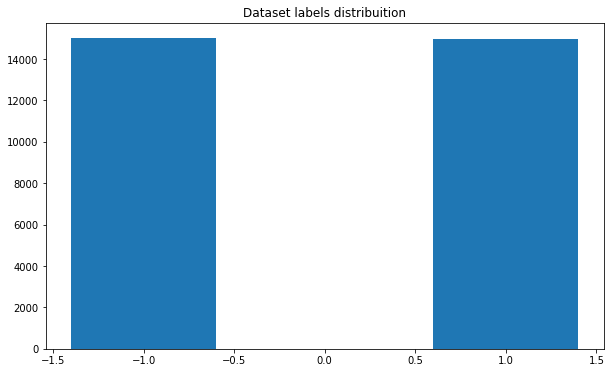

In [8]:
#Imorting counter to count no of negative tweets and no of positive tweets
size = 30000
from collections import Counter
target_cnt = Counter(dataset.target[:size])

plt.figure(figsize=(10,6))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [9]:
#preprocessing dataset


corpus = []
for i in range(0, size):
    # Removing unnecessary character such as '@', '?', etc
    tweet = re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+', ' ', dataset['text'][i])
    # converting all tweets to lowercase
    tweet = tweet.lower()
    # Splitting tweets by ' ' (space)
    tweet = tweet.split()
    # Imporing PorterStemmer for stemming
    ps = PorterStemmer()
    # Removing meaningless words such as 'a','this','there',etc
    # and then stemming them to their native form (Morpheme). ex - loved is converted to love     
    tweet = [ps.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
    # joining words with spaces and adding them to corpus
    tweet = ' '.join(tweet)
    corpus.append(tweet)

In [10]:
#Here you can see the difference between the earlier tweet and tweet after prepocessing
idx = 2
print("origingal tweet: " + dataset['text'][idx])
print("After proprocessing: " + corpus[idx])

origingal tweet: In the garden, learning lines... Scorching day! No more Welsh Col plays   great party last night though.
After proprocessing: garden learn line scorch day welsh col play great parti last night though


In [11]:
# Using count vectorizer to convert corpus into an array of 1 and 0.
# Where 1 after each column indicates that that word is in that tweet and 
# 0 indicates that word being not present int tweet
cv = CountVectorizer(max_features = 10000)
X = cv.fit_transform(corpus).toarray()
y = dataset.iloc[:size, 0].values

In [12]:
print("first tweet after vectorization :", X[0])

first tweet after vectorization : [0 0 0 ... 0 0 0]


In [13]:
print("Shape of X(tweets): ", X.shape)
print("ShAPE OF y(targets): ", y.shape)

Shape of X(tweets):  (30000, 10000)
ShAPE OF y(targets):  (30000,)


In [14]:
# Splitting Dataset into training set ans test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [15]:
#Defining a function to check accuracy of classifiers using confusion matrix
def check_accuracy(cm):
    true = (cm[0][0] + cm[1][1])
    total = np.sum(cm)
    accuracy = true/total
    return accuracy * 100

In [16]:
#First we use Gaussion Naive Bayes CLassifier
classifier = GaussianNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("Accuracy of Naive Bayes Classifier : " , check_accuracy(cm))

Accuracy of Naive Bayes Classifier :  54.85


In [17]:
#Now using logistic regression

classifier = LogisticRegression()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("Accuracy of Logistic Regression Classifier : " , check_accuracy(cm))

Accuracy of Logistic Regression Classifier :  73.63333333333333


### Now we try to see the Acurracy using LSTM.

In [18]:
#Using Tokenizer to generate tokens
tokenizer = Tokenizer(num_words=2500, lower=True,split=' ')
tokenizer.fit_on_texts(dataset['text'][:size].values)

In [19]:
#To see dictionary
print(tokenizer.word_index)

{'familiar': 6251, 'gabyjuarez': 32339, 'rossoneriblog': 29411, 'voyons': 8281, '6qbnz': 34195, 'naontiotami': 22005, 'beverly': 6893, 'bstreb24': 15219, 'bd': 23896, 'brave': 4522, 'respect': 4448, 'itgirlserena': 16688, 'terik': 30426, 'deleted': 1766, 'serves': 9715, 'xlilshanx': 17260, 'someplace': 24728, 'typos': 6193, 'pkgulati': 12232, 'forces': 7984, 'bridesmaid': 29654, 'bvictor': 12698, 'awi': 19608, 'bondoc': 39410, 'raul': 22276, 'litterature': 22199, 'maricampbell': 14807, 'guetta': 24566, 'thankyou': 1830, 'tomkrcha': 13346, 'cricket': 4582, 'viewers': 6364, 'lucasrotter': 24299, 'chemical': 5889, 'sap30': 26987, 'hyperren': 13547, 'niff': 25038, 'unproductive': 7728, 'bookmarking': 6419, 'lxnara': 32158, 'duttons': 33003, 'blur': 9982, 'portrait': 6852, 'burned': 1619, '2stacey': 27511, 'vimgpro': 21286, 'introvert': 28228, 'merked': 17991, 'sausage': 4408, 'uppercanuck': 22852, "'twibe'": 15022, 'theflyest1': 17933, 'pulling': 6099, '6tu41': 37662, 'balcony': 4714, 'sar

In [20]:
#Vectorizing the text corpus
X = tokenizer.texts_to_sequences(dataset['text'][:size].values)
# Using pad_sequences to ensure that all sequences in a list have the same length
X = pad_sequences(X)

In [21]:
# hyperparameters for our model

# dim : The embedding layer encodes the input sequence
#       into a sequence of dense vectors of dimension embed_dim.
# lstm_out : The LSTM transforms the vector sequence into a single vector of size lstm_out, 
#            containing information about the entire sequence.


embed_dim = 128
lstm_out = 200
batch_size = 32

In [22]:
#Defining our deep learning Model

model = Sequential()
model.add(Embedding(2500, embed_dim,input_length = X.shape[1]))
model.add(LSTM(lstm_out, dropout=0.25, recurrent_dropout=0.28))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [23]:
# MOdel Summary
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 128)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               263200    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 583,602
Trainable params: 583,602
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
#Splitting our dataset into training and test set
Y = pd.get_dummies(dataset['target'][:size]).values
X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y, test_size = 0.20, random_state = 36)

In [25]:
# Training/Fitting our model on train set
model.fit(X_train, Y_train, batch_size = batch_size, epochs = 2,  verbose = 5)

Epoch 1/2
Epoch 2/2


In [26]:
# Evaluating Our model on test set
score,acc = model.evaluate(X_valid, Y_valid, verbose=2, batch_size=batch_size)
print("score %.2f" %(score))
print("Validation accuracy: %.2f" %(acc))

score 0.46
Validation accuracy: 0.78


There are few changes that we could have done to increase the accuracy of our deep learning model

1. We can do a grid search in tensorflow to find out the best hyper-parameters for our model.
2. We can make our model more deep i.e., add few more layers which could increase the accuracy.
3. We could have use use Word2Vec Algorithm to generate word embeddings which could help in increasing accuracy.
4. Dataset size could have been increased.
5. Could have trained model for a greater number of epochs.

Due to unavailability of computation power our above suggested ways are not used.